## Goal: simulate a 1D boundary layer of a magma ocean planet

# Current goals and issues

1. The spatial pattern for the uniform forcing $F_0$ case looks fine. √
2. The time evolution for the uniform forcing $F_0$ case looks fine. √
3. The spartial pattern for the diffential forcing $F(x)$ case is problematic. Something is wrong in the advection or the boundary conditions. 

A. A solver for advection?

B. Periodic boundary condition?

In [66]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt 

In [140]:
# Create parameter class

class parameters:
    
    # Spatial grid
    rp   = 6314e3           # radius of the planet in m
    ndeg = 10                # number of X-grid
    ddeg = 1
    dx   = rp*np.pi/ndeg    # resolution of X-grid 
    x    = np.arange(0,ndeg+ddeg,ddeg)*dx        # X-grid in m
    xlen = len(x)           # length of X-grid
    
    # Temporal grid
    dt   = 180 # seconds
    tmin = 0
    tmax = dt * 1e5
    t    = np.arange(tmin,tmax+dt,dt)
    tlen = len(t)
    
    # CFL criterion must be met
    if not dt/dx < 0.4:
        print('CFL criterion is not met.')
        quit()
        
    # Thermodynamics of Atmosphere
    M  = 18e-3    # molar weight of the atmosphere, unit in kg/mol
    R  = 8.314/M  # gas constant of the amtosphere, unit in J/kg/K          
    cp = 1864     # specific heat of the atmosphere, unit in J/kg/K
    cv = cp-R     # specific heat, unit in J/kg/K
    L  = 2260e3   # latent heat of condensation, unit in J/kg
    
    # Thermodynamics of Ocean
    cpo  = 1 # speficic of the liquid in ocean, unit in J/kg/K， water is 4184
    rhoo = 1000 # density of the ocean, unit in kg/m^3
    ho   = 75 # depth of the ocean, unit in m
    Co  = cpo*rhoo*ho # heat capacity of the ocean per unit surface area, J/m^2/K
    
    # Clausius-Clapeyron relation
    pref = 3533 # reference pressure in Pa
    Tref = 300  # reference temperature in K
    
    # Other parameters
    F = 800      # solar heating in W/m2 
    g   = 10 * 1e5     # gravity in m/s^2
    tau = dt*1e20 # friction damping timescale in s
    sigma = 5.67e-8

In [106]:
def get_esat(x):
    # Saturation Vapor Pressure
    # Input x could be T or Ts in K
    esat = np.zeros([par.xlen],dtype='float')
    esat = par.pref * np.exp(-(par.L/par.R)*(1/x - 1/par.Tref))
    return esat

In [107]:
def get_p0():
    # generate parameters (Fnet, p0) with specific distributions
    # example: [par.Fnet, par.p0] = get_para(option = 2)
    
#     p_free  = 0.1 * get_esat((par.F/5.67e-8)**0.25)    # pressure of free Atmosphere in Pa (~10% of the hottest surface pressure)
    
    p_free  = 0
    
    p0_array = np.ones([par.xlen],dtype='float')
    p0_array = p0_array * p_free
    
    return p0_array

In [108]:
def __init__(self):
    # generate variables and combine them with parameters
    self.Ts , self.ps   , self.rhodel, self.E       ,\
    self.u  , self.rho  , self.delta,  self.Cm      ,\
    self.Cu , self.Fnet , self.Fsolar, self.OLR      \
    = (np.zeros([parameters.tlen,parameters.xlen],dtype='float') for i in range(12))

In [24]:
def get_Cm():
    # Diagnostic at current time step, i
    Cm = np.zeros([par.xlen],dtype='float')
    Cm = par.E[i,:]
    return Cm

In [25]:
def get_Cu():
    # Diagnostic at current time step, i
    Cu = np.zeros([par.xlen],dtype='float')
    
    for j in range(par.xlen):
        if par.E[i,j]>=0:
            Cu[j] = -par.rho[i,j]*par.delta[i,j]*par.u[i,j]/par.tau
            
        else:
            Cu[j] = -par.rho[i,j]  *par.delta[i,j]*par.u[i,j]/par.tau
            
    return Cu  

In [26]:
def get_Fnet(option = 1, evo = 0):
    # generate parameter (Fnet) with specific distributions
     
    # distribution of solar forcing
    if option == 1:     # uniform distribution
        F_solar = par.F * np.ones([par.xlen],dtype='float')
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
        
    elif option == 2:   # sine distribution (must be periodic)
        F_solar_initial = par.F * np.ones([par.xlen],dtype='float')
        
        F_solar_final = par.F * (np.sin(np.pi * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg) + 0.5) 
        n_step = 10000
        df = (F_solar_final - F_solar_initial)
        
        if evo < n_step:
            if max(abs(par.u[i,:]))<10000:
                evo = evo + 1
                if (evo%(n_step/10) == 0 ):
                    progress = round(evo/n_step*100)
                    print("Forcing evolution {} % completed".format(progress))
        F_solar = F_solar_initial + df * evo / n_step
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
    elif option == 3:   # sine distribution (must be periodic)
        F_solar_initial = par.F * np.ones([par.xlen],dtype='float')
        F_solar_sin = 0.01 * (np.sin(np.pi * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg)) 

        F_solar = F_solar_initial + F_solar_sin        
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
        
    else:               # no forcing
        Fnet = np.zeros([par.xlen],dtype='float')

    return Fnet, F_solar, evo

In [27]:
def get_Ts(): 
    # Prognostic
    Ts = np.zeros([par.xlen],dtype='float')

    Ts = par.Ts[i,:] + par.dt / par.Co*\
            (
             par.Fnet[i,:] - par.L * par.E[i,:]
            )
    
    if any(n < 0 for n in Ts):
        print("Error, Ts is {} K".format(Ts))
        print("Ts before the error is {}".format(par.Ts[i,:]))
        print("F_net is {}".format(par.Fnet[i,:]))
        print("Net phase change is {}".format(par.E[i,:]))
        
    return Ts

In [28]:
def get_ps(): 
    # Diagnostic
    ps = np.zeros([par.xlen], dtype='float')
    
    ps = get_esat(par.Ts[i+1, :])
    return ps

In [29]:
def get_rhodel(): 
    # Diagnostic
    rhodel = np.zeros([par.xlen],dtype='float')
    
    # interior (here -1 is required!!)
    rhodel[:] = (par.ps[i+1, :] - par.p0[:]) / par.g
    
    if (any(n < 0 for n in rhodel) == True):
        print("Minimum surface pressure Ps is {} Pa ".format(min(par.ps[i+1,:])))
        print('P_{free} too high! Quit.')
        quit()
    
    return rhodel

In [30]:
# def get_adv(f, u):
#     u_mid = np.zeros([par.xlen],dtype='float')
#     F = np.zeros([par.xlen],dtype='float')
#     adv = np.zeros([par.xlen],dtype='float')
    
#     # calculate the wind speeds at the midgrids from 
#     # j = 1/2 to j = length+1/2 (in other words, -1/2)
#     for j in range(0, par.xlen):
#         if j == par.xlen - 1:   # right edge
#             u_mid[j] = 1/2 * (u[j] + u[0])         
#             if u_mid[j] > 0:
#                 F[j] = f[j]
#             elif u_mid[j] < 0:
#                 F[j] = f[0]
#             else:
#                 F[j] = 0
#         else:                   # left edge and interior
#             u_mid[j] = 1/2 * (u[j] + u[j+1])
#             if u_mid[j] > 0:
#                 F[j] = f[j]
#             elif u_mid[j] < 0:
#                 F[j] = f[j+1]
#             else:
#                 F[j] = 0
  
#     # calculate the advections based on fluxes
#     for j in range(0, par.xlen):
#         if j == 0:              # left edge
#             adv[j] = (F[j] - F[-1]) / par.dx
#         else:                   # right edge
#             adv[j] = (F[j] - F[j-1]) / par.dx
    
#     if np.sum(adv[:]) != 0.0:
#         print('Advection is not conserved!')
#         print("The integral of advection is {}".format(np.sum(adv[:])))
#         print("Advection is {}".format(adv))
#         print("Fluxes are {}".format(F))
#         print("Winds at the midgrids are {}".format(u_mid))
        
#     return adv

In [101]:
def get_adv_LF(q, f, u):                                                  # The Lax–Friedrichs Method
    u_mid = np.zeros([par.xlen],dtype='float')
    F = np.zeros([par.xlen],dtype='float')
    adv = np.zeros([par.xlen],dtype='float')
    
    # calculate the wind speeds at the midgrids from j = 1/2 to j = length+1/2 (in other words, -1/2)
    for j in range(0, par.xlen):
        if j == par.xlen - 1:   # right edge        
            F[j] = (f[0]+f[j]) / 2 - par.dx/2/par.dt*(q[0] - q[j])  # The Lax–Friedrichs Method
        else:                   # left edge and interior
            F[j] = (f[j] + f[j+1]) / 2 - par.dx/2/par.dt*(q[j+1] - q[j]) # The Lax–Friedrichs Method
  
    # calculate the advections based on fluxes
    for j in range(0, par.xlen):
        if j == 0:              # left edge
            adv[j] = (F[j] - F[-1]) / par.dx
        else:                   # right edge
            adv[j] = (F[j] - F[j-1]) / par.dx
        
    return adv

In [31]:
# def get_advU(rho, delta, p, u):
#     advX = np.zeros([par.xlen],dtype='float') # (t+1)
    
#     mum = (rho * u**2 + p / 2) * delta
    
#     for j in range(1, par.xlen-1):
#         if u[j] >=0:
#             advX[j] = (mum[j] - mum[j-1]) / par.dx
#         else:
#             advX[j] = (mum[j+1] - mum[j]) / par.dx
    
#     if u[0] >=0:
#         advX[0] = (mum[0] - mum[-1]) / par.dx
#     else:
#         advX[0] = (mum[1] - mum[0]) / par.dx
    
#     if u[-1] >=0:
#         advX[-1] = (mum[-1] - mum[-2]) / par.dx
#     else:
#         advX[-1] = (mum[0] - mum[-1]) / par.dx
            
#     return advX

In [103]:
def get_u(): 
    # Prognostic
    rhodelu = np.zeros([par.xlen],dtype='float') # (t+1)
    u = np.zeros([par.xlen],dtype='float')       # (t+1)
    
    term1 = par.rho[i,:] * par.u[i,:] * par.delta[i,:]
    term2 = (par.rho[i,:] * par.u[i,:]**2 + par.ps[i,:] / 2) * par.delta[i,:]
    
#     advU = get_adv(mum, par.u[i,:])
    advU = get_adv_LF(term1, term2, par.u[i,:])
#     print("The sum of momentum advection is {}".format(sum(advU[:])))
#     print((advU[:]))
#     print()
    
    for j in range(0, par.xlen):
        rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] + par.dt*(par.Cu[i,j] - advU[j])

    u = rhodelu / par.rhodel[i+1,:]
    
    return u

In [33]:
def get_rho():
    # Diagnostic
    rho = np.zeros([par.xlen],dtype='float') # (t+1)
#     rho = par.p[i+1,:]/(par.R * par.T[i+1,:])
    rho = par.ps[i+1,:]/(par.R * par.Ts[i+1,:])
    return rho

In [34]:
def get_delta():
    # Diagnostic
    delta = np.zeros([par.xlen],dtype='float') # (t+1)
    delta = par.rhodel[i+1,:]/par.rho[i+1,:]
    return delta

In [104]:
def get_E(): # **
    # Diagnostic
    E = np.zeros([par.xlen],dtype='float') # (t+1)
      
    alpha = (par.ps[i+1,:] * par.L**2) / (par.R*par.Ts[i+1,:]**2*par.Co*par.g)
#     print("alpha = {}".format(alpha))

#     print('mass advection is calculated')
    term1 = par.rho[i+1,:]*par.delta[i+1,:]
    term2 = par.rho[i+1,:]*par.delta[i+1,:]*par.u[i+1,:]
    advM = get_adv_LF(term1, term2, par.u[i+1,:])
#     print(sum((advM[:])))
          
    for j in range(0, par.xlen):
        E[j] = (alpha[j] * par.Fnet[i+1,j]/par.L + advM[j]) / (alpha[j] + 1)

    return E

In [135]:
def get_initial_conditions(Ts0 = 340, u0 = 0):
    # Scenario: intially homogeneous atmosphere with uniform Ts, p, delta,etc.
    par.p0 = get_p0()
    
    i = 0
    
    par.Ts[i,:]       = np.ones([par.xlen],dtype='float') * Ts0  # uniform initial temp
    par.ps[i,:]       = get_esat(par.Ts[i,:])                    # uniform initial pressure
    par.rhodel[i,:]   = (par.ps[0,:]-par.p0[:])/par.g            # uniform atmospheric mass
    par.u[i,:]        = np.ones([par.xlen],dtype='float') * u0   # initial wind
    par.rho[i,:]      = par.ps[0,:]/(par.R*par.Ts[0,:])
    par.delta[i,:]    = par.rhodel[0,:]/par.rho[0,:]          
    
    # uniform initial solar forcing
    F_solar = par.F * np.ones([par.xlen],dtype='float')
    par.Fnet[i,:] = F_solar - par.sigma * par.Ts[i,:] **4
    par.Fsolar[i,:] = F_solar
        
    par.E[i,:]    = np.zeros([par.xlen],dtype='float')      
    alpha = (par.ps[i,:] * par.L**2) / (par.R * par.Ts[i,:] ** 2 * par.Co * par.g)
    
#     print('initial advection is calculated')
    advM = get_adv(par.rho[i,:]*par.delta[i,:], par.u[i,:])
    for j in range(0, par.xlen):
        par.E[i, j] = (alpha[j] * par.Fnet[i,j] + advM[j]) / (alpha[j]*par.L + 1)

In [141]:
# Time Integration
par = parameters()
__init__(par)
get_initial_conditions()
evo = 0

for i in range(par.tlen-1): 
    # Get variables at current time step
    par.Cm[i,:]         = get_Cm()
    par.Cu[i,:]         = get_Cu()

    # Get variables at the next time step
    par.Ts[i+1,:]                               = get_Ts()
    [par.Fnet[i+1,:], par.Fsolar[i+1,:], evo]   = get_Fnet(option=2, evo=evo)
    par.ps[i+1,:]                               = get_ps()
    par.rho[i+1,:]                              = get_rho()
    par.rhodel[i+1,:]                           = get_rhodel()
    par.delta[i+1,:]                            = get_delta() 
    par.u[i+1,:]                                = get_u()          
    par.E[i+1,:]                                = get_E() 
    
    f_report = 10                               # report every time when this fraction is completed
    idx = (par.tlen-1)/f_report
    if (i%idx == 0 ):
        progress = round(i/par.tlen*100)
        print("Simulation {} % completed".format(progress))
        
print('Success!')

Simulation 0 % completed
Forcing evolution 10 % completed
Forcing evolution 20 % completed
Forcing evolution 30 % completed
Forcing evolution 40 % completed
Forcing evolution 50 % completed
Forcing evolution 60 % completed
Forcing evolution 70 % completed
Forcing evolution 80 % completed
Forcing evolution 90 % completed
Forcing evolution 100 % completed
Simulation 10 % completed
Simulation 20 % completed
Simulation 30 % completed
Simulation 40 % completed
Simulation 50 % completed
Simulation 60 % completed
Simulation 70 % completed
Simulation 80 % completed
Simulation 90 % completed
Success!


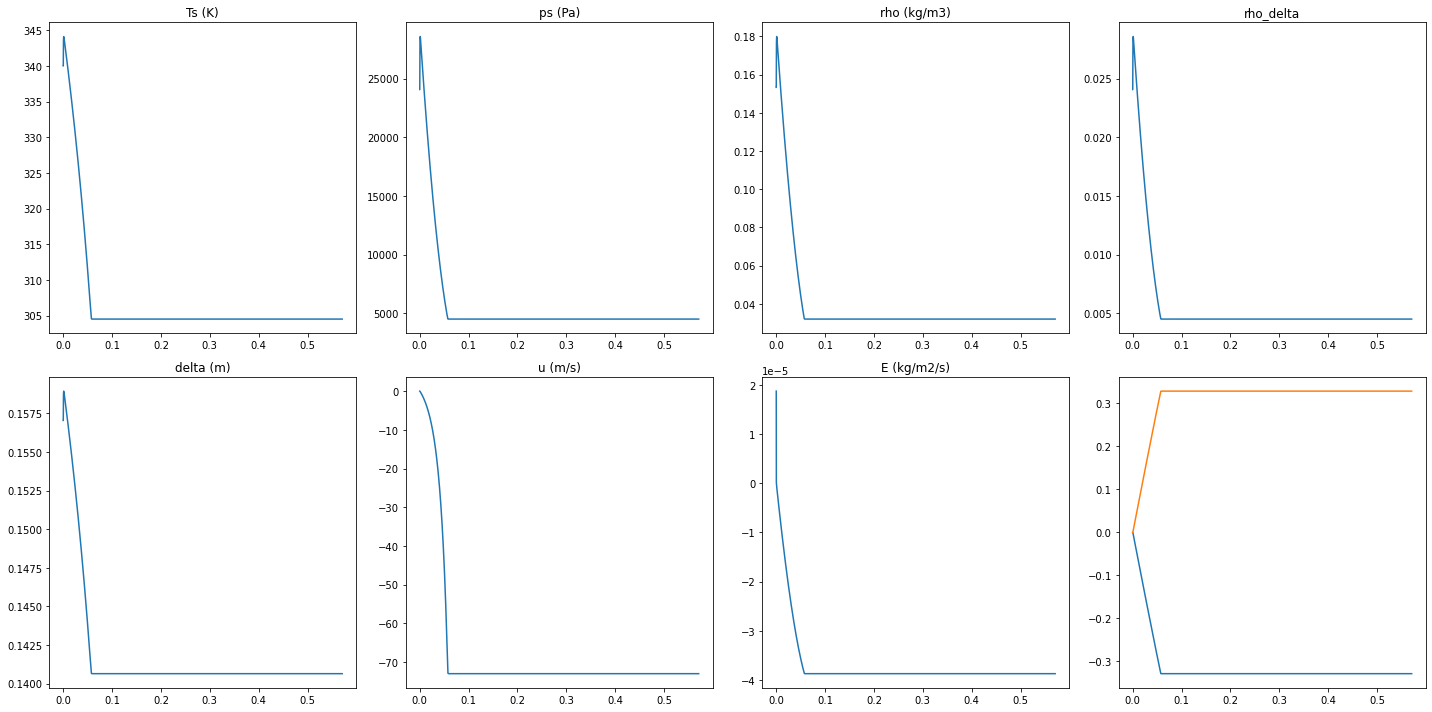

In [155]:
# Plot time-evolution  
fig, ax = plt.subplots(2,4,figsize=(20,10)) 

L_year = 3600*24*365

# Plot at end of the simulation
ax[0,0].plot(par.t/L_year,par.Ts[:,0]) 
ax[0,1].plot(par.t/L_year,par.ps[:,0]) 
ax[0,2].plot(par.t/L_year,par.rho[:,0]) 
ax[0,3].plot(par.t/L_year,par.rhodel[:,0]) 
ax[1,0].plot(par.t/L_year,par.delta[:,0])
ax[1,1].plot(par.t/L_year,par.u[:,0]) 
ax[1,2].plot(par.t/L_year,par.E[:,0])
ax[1,3].plot(par.t/L_year,par.rho[:,0]*par.delta[:,0]*par.u[:,0])
ax[1,3].plot(par.t/L_year,par.rho[:,-1]*par.delta[:,-1]*par.u[:,-1])

ax[0,0].set_title('Ts (K)')
ax[0,1].set_title('ps (Pa)')
ax[0,2].set_title('rho (kg/m3)')
ax[0,3].set_title('rho_delta')
ax[1,0].set_title('delta (m)')
ax[1,1].set_title('u (m/s)')
ax[1,2].set_title('E (kg/m2/s)')

# for i in (0,1):
#     for j in (0,4):
#         ax[i,j].set_xlim([0.3, 0.6])

plt.tight_layout()
plt.show()

In [143]:
# print(par.Ts[:,0])
# print(par.ps[:,0])
# print(par.rhodel[:,0])
# print(par.e[:,0])
# print(par.T[:,0])
# print(par.p[:,0])
# print(par.rho[:,0])
# print(par.delta[4,:])
print(par.u[:,0])
print(par.E[:,0])
alpha = (par.ps[-1,:] * par.L**2) / (par.R*par.Ts[-1,:]**2*par.Co*par.g)
print(alpha)
termA = alpha*par.Fnet[-1,:]/par.L
print(termA)
term1 = par.rho[-1,:]*par.delta[-1,:]
term2 = par.rho[-1,:]*par.delta[-1,:]*par.u[-1,:]
termB = get_adv_LF(term1, term2, par.u[i+1,:])
print(termB)
# term1 = par.rho[-1,:] * par.u[-1,:] * par.delta[-1,:]
# term2 = (par.rho[-1,:] * par.u[-1,:]**2 + par.ps[-1,:] / 2) * par.delta[-1,:]
# advU = get_adv_LF(term1, term2, par.u[-1,:])
# print(advU)

[  0.           0.           0.         ... -73.00647989 -73.00647989
 -73.00647989]
[ 1.87154329e-05  5.56920538e-07  5.46568068e-07 ... -3.87084693e-05
 -3.87084693e-05 -3.87084693e-05]
[0.00715082 0.02426324 0.04842905 0.07203771 0.08889683 0.09498043
 0.08889683 0.07203771 0.04842905 0.02426324 0.00715082]
[-2.76797392e-07 -5.97458849e-07 -2.23901319e-07  1.19883630e-06
  2.87179612e-06  3.61100050e-06  2.87179612e-06  1.19883630e-06
 -2.23901319e-07 -5.97458849e-07 -2.76797392e-07]
[-3.87084693e-05 -2.46240346e-05 -4.62328546e-06  1.66417881e-05
  3.23048197e-05  3.80183632e-05  3.23048197e-05  1.66417881e-05
 -4.62328546e-06 -2.46240346e-05 -3.87084693e-05]


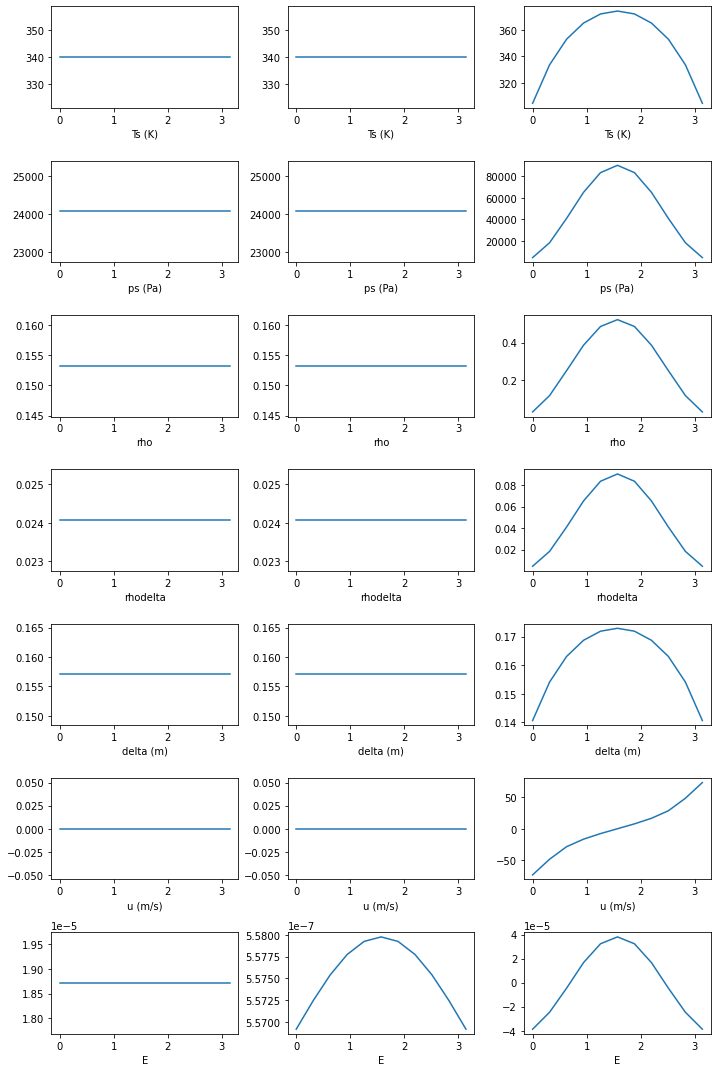

In [144]:
# Plot distribution  
fig, ax = plt.subplots(7,3,figsize=(10,15)) 

# Plot at end of the simulation
ax[0,0].plot(par.x/par.rp,par.Ts[0,:]) 
ax[1,0].plot(par.x/par.rp,par.ps[0,:]) 
ax[2,0].plot(par.x/par.rp,par.rho[0,:]) 
ax[3,0].plot(par.x/par.rp,par.rhodel[0,:])
ax[4,0].plot(par.x/par.rp,par.delta[0,:])
ax[5,0].plot(par.x/par.rp,par.u[0,:]) 
ax[6,0].plot(par.x/par.rp,par.E[0,:])

i = 1
ax[0,1].plot(par.x/par.rp,par.Ts[i,:]) 
ax[1,1].plot(par.x/par.rp,par.ps[i,:]) 
ax[2,1].plot(par.x/par.rp,par.rho[i,:]) 
ax[3,1].plot(par.x/par.rp,par.rhodel[i,:])
ax[4,1].plot(par.x/par.rp,par.delta[i,:])
ax[5,1].plot(par.x/par.rp,par.u[i,:])  
ax[6,1].plot(par.x/par.rp,par.E[i,:])

i = -1
ax[0,2].plot(par.x/par.rp,par.Ts[i,:]) 
ax[1,2].plot(par.x/par.rp,par.ps[i,:]) 
ax[2,2].plot(par.x/par.rp,par.rho[i,:]) 
ax[3,2].plot(par.x/par.rp,par.rhodel[i,:])
ax[4,2].plot(par.x/par.rp,par.delta[i,:])
ax[5,2].plot(par.x/par.rp,par.u[i,:])  
ax[6,2].plot(par.x/par.rp,par.E[i,:])

for c in range(0,3):    
    ax[0,c].set_xlabel('Ts (K)')
    ax[1,c].set_xlabel('ps (Pa)')
    ax[2,c].set_xlabel('rho')
    ax[3,c].set_xlabel('rhodelta')
    ax[4,c].set_xlabel('delta (m)')
    ax[5,c].set_xlabel('u (m/s)')
    ax[6,c].set_xlabel('E')
plt.tight_layout()
plt.show()

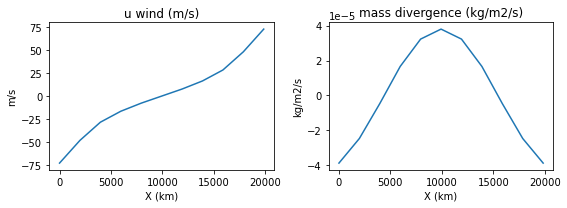

In [167]:
# Plot distribution  
fig, ax = plt.subplots(1,2,figsize=(8,3)) 

# Plot at end of the simulation
ax[0].plot(par.x/1e3,par.u[-1,:])
ax[1].plot(par.x/1e3,termB) 

ax[0].set_title('u wind (m/s)')
ax[1].set_title('mass divergence (kg/m2/s)')
ax[0].set_xlabel('X (km)')
ax[1].set_xlabel('X (km)')
ax[0].set_ylabel('m/s')
ax[1].set_ylabel('kg/m2/s')

plt.tight_layout()
plt.show()

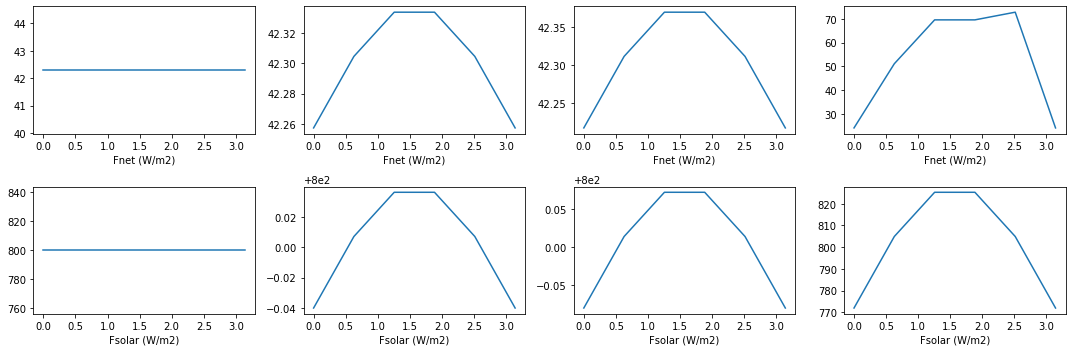

In [ ]:
# Plot distribution  
fig, ax = plt.subplots(2,4,figsize=(15,5)) 

# Plot at end of the simulation
ax[0,0].plot(par.x/par.rp,par.Fnet[0,:]) 
ax[1,0].plot(par.x/par.rp,par.Fsolar[0,:]) 

# Plot at end of the simulation
ax[0,1].plot(par.x/par.rp,par.Fnet[1,:]) 
ax[1,1].plot(par.x/par.rp,par.Fsolar[1,:]) 

# Plot at end of the simulation
ax[0,2].plot(par.x/par.rp,par.Fnet[2,:]) 
ax[1,2].plot(par.x/par.rp,par.Fsolar[2,:]) 

# Plot at end of the simulation
j = 700
ax[0,3].plot(par.x/par.rp,par.Fnet[j,:]) 
ax[1,3].plot(par.x/par.rp,par.Fsolar[j,:]) 

for c in range(0,4):    
    ax[0,c].set_xlabel('Fnet (W/m2)')
    ax[1,c].set_xlabel('Fsolar (W/m2)')
plt.tight_layout()
plt.show()

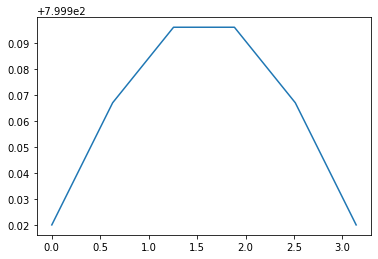

In [ ]:
plt.plot(par.x/par.rp,par.Fsolar[-1,:])

In [ ]:
for j in range(1, par.xlen):
    print(j)

1
2
3
4
5


In [ ]:
print(par.dt)
print(par.dx)
print(par.dt/par.dx)


180
3967203.202953191
4.5372014185209314e-05
